In [1]:
import os
import numpy as np
from astropy.table import Table, vstack, join
from scipy.stats import gaussian_kde
import seaborn as sns
import pandas as pd

import matplotlib
import matplotlib.pylab as plt
import matplotlib.gridspec as gridspec
from matplotlib import colors
from matplotlib.colors import LogNorm
from matplotlib import patches
from matplotlib import rcParams
#rcParams['text.usetex'] = True
#rcParams["axes.grid"]   = False
rcParams["xtick.labelsize"] = 13
rcParams["ytick.labelsize"] = 13

from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from matplotlib.ticker import FormatStrFormatter
font = {'family': 'serif', 'color':  'black', 'weight': 'normal','size': 14}

from scipy.stats import linregress

# Additional test plots

In [8]:
# Complete Cantat-Gaudin+2020 Table 1
nntable = Table.read("data/CantatGaudin2020_table1.fits")
nntable["Cluster"] = [np.char.strip(a, ' ') for a in nntable["Cluster"]]
nntable_age_nonull = nntable[ nntable["AgeNN"]!= 0. ]

# Results of our analysis (separate files for the Tarricq+ and Cantat+ membership lists):
tarricqres = Table.read("data/mcmc_results_tarricq_summary.fits")
cantatres  = Table.read("data/mcmc_results_cantat_summary.fits")
# Join the two subtables
jointres   = vstack([tarricqres, cantatres])
jointres["Cluster"] = np.array([np.char.strip(a, ' ') for a in jointres["clus"]], dtype="S17")
mergedtable = join(nntable, jointres, join_type='inner')
print("Total number of OCs closer than 1.5 kpc studied through MCMC:", len(mergedtable))

# Results of our analysis:
# - all OCs are at d < 1.5 kpc
# - there are 251 OCs in total, 172 from Tarricq+2022 catalogue and 79 from Cantat-Gaudin+2020 catalogue.
finaltable = Table.read("data/Catalogue_observed_251_OCs_binaryfraction.fits")
print("Final number of selected OCs closer than 1.5 kpc studied through MCMC:", len(finaltable))

# Results for the simulated clusters
sim_OCs = Table.read("data/Catalogue_simulated_324OCs.fits")

Total number of OCs closer than 1.5 kpc studied through MCMC: 379
Final number of selected OCs closer than 1.5 kpc studied through MCMC: 251


## Results histograms MCMC analysis

0.1832576 0.6235728


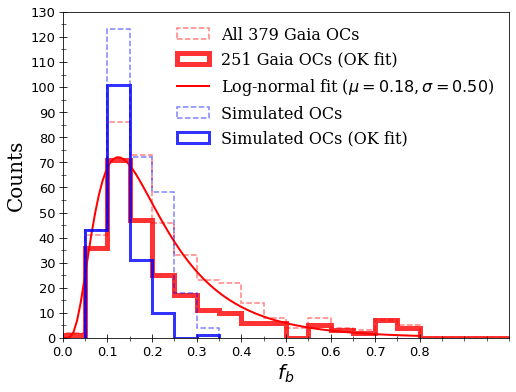

In [13]:
fig = plt.figure(figsize=(8,6))
ax = plt.subplot(111)
#plt.axis([6,10,0,.9])
ax.set_xlabel(r"$f_{b}$", fontdict=font, fontsize=20)
ax.set_ylabel("Counts", fontdict=font, fontsize=20)
#plt.title("Age distribution", fontsize=16)
plt.xticks(np.arange(0.0, 0.9, step=0.1))
plt.yticks(np.arange(0, 140, step=10))
ax.tick_params(which="major", direction='inout', length=8.)
ax.tick_params(which="minor", direction='inout', length=5.)
ax.xaxis.set_minor_locator(MultipleLocator(0.05))
ax.yaxis.set_minor_locator(MultipleLocator(5))
plt.xlim(0.0, 1.)
plt.ylim(0, 130)

binBoundaries = np.linspace(0.0, 1.0, round(1./0.05)+1)
binBoundaries_common = np.linspace(0.05, 0.40, round(0.35/0.05)+1)
binBoundaries_sim = np.linspace(0.05, 0.35, round(0.30/0.05)+1)
# --------------------------------------

# MCMC BF histogram for observed OCs
BFvals  = mergedtable["fb_50"]
vals, bins, patches = plt.hist(BFvals, density=False, histtype="step", ls="dashed", bins=binBoundaries, lw=1.5,
                               label="All 379 Gaia OCs", alpha=0.5, color="red", zorder=0)
# MCMC BF histogram for observed OCs
BFvals  = finaltable["fb_50"]
vals, bins, patches = plt.hist(BFvals, density=False, histtype="step", bins=binBoundaries, lw=5,
                               label="251 Gaia OCs (OK fit)", alpha=0.8, color="red", zorder=0)

# Try a log-normal fit
from scipy import stats
s, loc, scale = stats.lognorm.fit(BFvals, floc=0)
x_fit = np.linspace(0,0.8,100)
pdf_fitted = stats.lognorm.pdf(x_fit,s,loc,scale) #Gives the PDF
plt.plot(x_fit, 17*pdf_fitted, c="r", label="Log-normal fit ($\mu=0.18, \sigma=0.50$)", zorder=1, lw=2)
print(scale, s)

# first select OCs with OK Delta G
#ok = (sim_OCs["mean_sB_50"] <= 0.25) * (sim_OCs["mean_sM_50"] <= 0.20) * (abs(sim_OCs["mean_DG_50"]+0.75) <= 0.1)
ok = (sim_OCs["mean_sB_50"] <= 0.22) * (abs(sim_OCs["mean_DG_50"]+0.75) <= 0.05)

BFvals  = (sim_OCs["mean_fb_50"])
vals, bins, patches = plt.hist(BFvals, density=False, histtype="step", ls="dashed", bins=binBoundaries_sim, lw=1.5,
                               label="Simulated OCs", alpha=0.5, color="blue")  #filled
BFvals  = (sim_OCs[ok]["mean_fb_50"])
vals, bins, patches = plt.hist(BFvals, density=False, histtype="step", bins=binBoundaries_sim, lw=3,
                               label="Simulated OCs (OK fit)", alpha=0.8, color="blue")  #filled

#get handles and labels
handles, labels = plt.gca().get_legend_handles_labels()
#specify order of items in legend
order = [1,2,0,3,4]
#add legend to plot
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], 
           loc="upper right", prop={"family":"serif", 'size': 16}, framealpha=0.0)

#plt.tight_layout()
plt.savefig("im/MCMC_BF_histo.png", dpi=300)

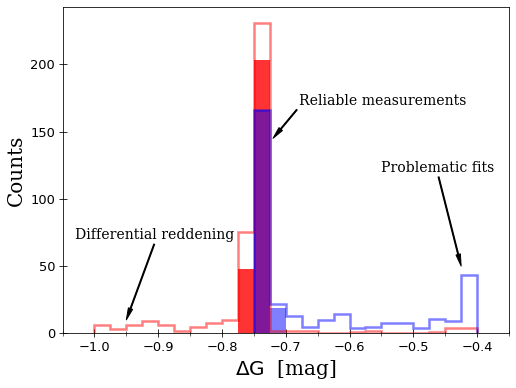

In [15]:
fig = plt.figure(figsize=(8,6))
ax = plt.subplot(111)
ax.set_xlabel(r"${\Delta \rm G}$  [mag]", fontdict=font, fontsize=20)
ax.set_ylabel("Counts", fontdict=font, fontsize=20)
plt.xticks(np.arange(-1.0, -0.3, step=0.1))
ax.tick_params(which="major", direction='inout', length=8.)
ax.tick_params(which="minor", direction='inout', length=5.)
ax.xaxis.set_minor_locator(MultipleLocator(0.05))
plt.xlim(-1.05, -0.35)

binBoundaries = np.linspace(-1.0, -0.4, round(0.6/0.025)+1)
binBoundaries_common = np.linspace(-0.8, -0.4, round(0.4/0.025)+1)
binBoundaries_sim = np.linspace(-0.75, -0.4, round(0.35/0.025)+1)
# --------------------------------------
# MCMC deltaG histogram for observed OCs
BFvals  = mergedtable["DG_50"]
vals, bins, patches = plt.hist(BFvals, density=False, histtype="step", bins=binBoundaries, lw=2.5,
                               label="Gaia OCs", alpha=0.5, color="red")
# MCMC deltaG histogram for observed OCs (OK fit)
BFvals  = finaltable["DG_50"]
vals, bins, patches = plt.hist(BFvals, density=False, histtype="stepfilled", bins=binBoundaries, lw=4,
                               label="Gaia OCs", alpha=0.8, color="red")

# MCMC deltaG histogram for simulated OCs
BFvals  = (sim_OCs["mean_DG_50"])
vals, bins, patches = plt.hist(BFvals, density=False, histtype="step", bins=binBoundaries_sim, lw=2.5,
                               label="Simulated OCs", alpha=0.5, color="blue")  #filled
# MCMC deltaG histogram for simulated OCs (OK)
BFvals  = (sim_OCs[ok]["mean_DG_50"])
vals, bins, patches = plt.hist(BFvals, density=False, histtype="stepfilled", bins=binBoundaries_sim, lw=2.5,
                               label="Simulated OCs (OK fit)", alpha=0.5, color="blue")  #filled

#plt.legend(loc="upper right", prop={"family":"serif", 'size': 14}, framealpha=0.0)

plt.annotate("Reliable measurements", (-.72, 145), xytext=(-.68, 170), xycoords='data', 
             textcoords=None, arrowprops={"width":1, "headwidth":4.5, "color":"k"}, annotation_clip=None, 
             fontsize=14, fontfamily='serif')
plt.annotate("Differential reddening", (-.95, 10), xytext=(-1.03, 70), xycoords='data', 
             textcoords=None, arrowprops={"width":1, "headwidth":4.5, "color":"k"}, annotation_clip=None, 
             fontsize=14, fontfamily='serif')
plt.annotate("Problematic fits", (-.425, 50), xytext=(-.55, 120), xycoords='data', 
             textcoords=None, arrowprops={"width":1, "headwidth":4.5, "color":"k"}, annotation_clip=None, 
             fontsize=14, fontfamily='serif')
#plt.tight_layout()
plt.savefig("im/MCMC_deltaG_histo.png", dpi=300)

## Histogram of $q_{\rm lim}$ from the simulations

In the simulations we know exactly how many single and binary stars there are, and which mass ratios they have. 
We can therefore calculate, for a given limiting $q_{\rm lim}$, the binary fraction, and compare it to the one 
inferred with MCMC. The optimal value (where ground truth and MCMC match) is called $q_{\rm lim}^{\rm sim}$:

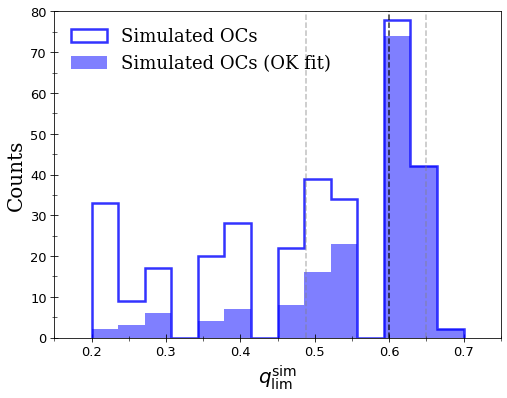

In [16]:
fig = plt.figure(figsize=(8,6))
ax = plt.subplot(111)
#plt.axis([6,10,0,.9])
ax.set_xlabel(r"$q_{\rm lim}^{\rm sim}$", fontdict=font, fontsize=20)
ax.set_ylabel("Counts", fontdict=font, fontsize=20)
#plt.title("Age distribution", fontsize=16)
plt.xticks(np.arange(0.0, 0.9, step=0.1))
plt.yticks(np.arange(0, 140, step=10))
ax.tick_params(which="major", direction='inout', length=8.)
ax.tick_params(which="minor", direction='inout', length=5.)
ax.xaxis.set_minor_locator(MultipleLocator(0.05))
ax.yaxis.set_minor_locator(MultipleLocator(5))
plt.xlim(0.15, 0.75)
plt.ylim(0, 80)

binBoundaries = np.linspace(0.2, 0.7, round(0.7/0.05)+1)
binBoundaries_common = np.linspace(0.05, 0.40, round(0.35/0.05)+1)
binBoundaries_sim = np.linspace(0.05, 0.35, round(0.30/0.05)+1)
# --------------------------------------

# MCMC BF histogram for simulated OCs

# first select OCs with OK Delta G
#ok = (sim_OCs["mean_sB_50"] <= 0.25) * (sim_OCs["mean_sM_50"] <= 0.20) * \
#     (abs(sim_OCs["mean_DG_50"]+0.75) <= 0.05)

BFvals  = (sim_OCs["m_r_closer_BF_to_sim_MCMC"])
vals, bins, patches = plt.hist(BFvals, density=False, histtype="step", bins=binBoundaries, lw=2.5,
                               label="Simulated OCs", alpha=0.8, color="blue")  #filled
BFvals  = (sim_OCs[ok]["m_r_closer_BF_to_sim_MCMC"])
vals, bins, patches = plt.hist(BFvals, density=False, histtype="stepfilled", bins=binBoundaries, lw=2.5,
                               label="Simulated OCs (OK fit)", alpha=0.5, color="blue")  #filled

percentiles = np.percentile(sim_OCs[ok]["m_r_closer_BF_to_sim_MCMC"], [16, 50, 84])
for ii in [0,1,2]:
    if ii == 1:
        plt.axvline(percentiles[ii], c="k", alpha=.8, ls="dashed")
    else:
        plt.axvline(percentiles[ii], c="grey", alpha=.5, ls="dashed")

plt.legend(prop={"family":"serif", 'size': 18}, framealpha=0.0, loc="upper left")

#plt.tight_layout()
plt.savefig("im/MCMC_qlim_histo.png", dpi=300)

## Mass dependence

In [19]:
maximum_bf_sigu_sigl_sum = 0.8 # This has no effect because all our studied OCs have it smaller.

251 clusters with ages and ok f_b uncertainties


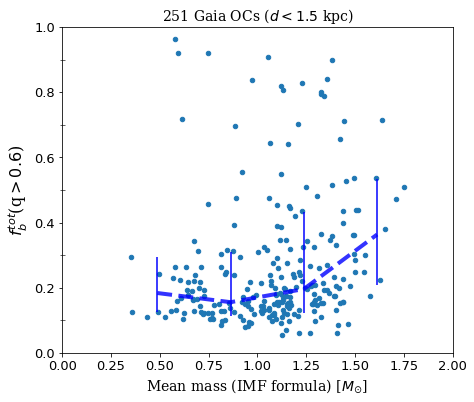

In [56]:
fig = plt.figure(figsize=(7,6))
ax = plt.subplot(111)
plt.axis([0.,2.,0,1.00])
ax.set_xlabel(r"Mean mass (IMF formula) [$M_{\odot}$]", fontdict=font)
ax.set_ylabel(r"$f_{b}^{ tot}$(q$>0.6$)", fontsize=16, fontdict=font)

ax.yaxis.set_minor_locator(MultipleLocator(0.1))
ax.tick_params(which="minor", direction='inout', length=5.)

ok = (finaltable["AgeNN"] > 0) & \
(finaltable["fb_sigu"]+finaltable["fb_sigl"] < maximum_bf_sigu_sigl_sum)
print(sum(ok), "clusters with ages and ok f_b uncertainties")

sc = ax.scatter(finaltable["mean_mass"][ok], finaltable["fb_tot_qlim06"][ok],
               # marker="o", c=finaltable["mean_mass"], vmin=0.2, vmax=1.8,
                s=20, label="_nolegend_", cmap="inferno", zorder=10)
#cb = plt.colorbar(sc)
#cb.set_label(r"Mean main-sequence mass [M$_{\odot}$]", fontsize=14, fontdict=font)
#cb.ax.tick_params(labelsize=12)

plt.title(r"251 Gaia OCs ($d<1.5$ kpc)", fontdict=font)

# Overplot running median
total_bins = 5
bins = np.linspace(0.3, 1.8, total_bins)
delta = bins[1]-bins[0]
stat = np.zeros((total_bins, 3))   # list of total_bins elements, with 3 elements each

# automatic calculation of the quantiles:
for k in np.arange(total_bins-1):
    stat[k,:] = np.quantile(finaltable["fb_tot_qlim06"][ok & ((finaltable["mean_mass"][ok]) > bins[k]) & ((finaltable["mean_mass"][ok]) < bins[k+1])],
                         [.16,.50,.84])
# y axis has the middle component (50th percentile, median) for all rows: for all middeling positions of the bins.
plt.errorbar(bins+delta/2,stat[:,1], yerr=[stat[:,1]-stat[:,0], stat[:,2]-stat[:,1]], c="b", fmt="none", zorder=20)
# it also plots the 9th errorbar, but as it is full of 0's, we don't see it.
# It is necessary to plot bins without the last element, because for this no stats is calculated (it is the last right border)
plt.plot(bins[:-1]+delta/2,stat[:-1, 1],'b--',lw=4, alpha=.8, zorder=30)

plt.savefig("im/mass_BF_tot.png", dpi=300)

187 clusters with ages and ok f_b uncertainties


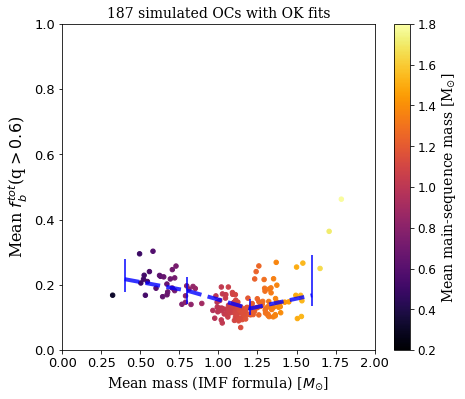

In [61]:
fig = plt.figure(figsize=(7,6))
ax = plt.subplot(111)
plt.axis([0.,2,0,1.00])
ax.set_xlabel(r"Mean mass (IMF formula) [$M_{\odot}$]", fontdict=font)
ax.set_ylabel(r"Mean $f_{b}^{ tot}$(q$>0.6$)", fontsize=16, fontdict=font)

ax.yaxis.set_minor_locator(MultipleLocator(0.2))
ax.tick_params(which="minor", direction='inout', length=5.)

ok = (sim_OCs["mean_sB_50"] <= 0.22) * (abs(sim_OCs["mean_DG_50"]+0.75) <= 0.05) * (sim_OCs["mean_fb_sigu"]+sim_OCs["mean_fb_sigl"] < maximum_bf_sigu_sigl_sum)
print(sum(ok), "clusters with ages and ok f_b uncertainties")

sc = ax.scatter(sim_OCs["mean_mass"][ok], sim_OCs["mean_fb_tot_greater06"][ok],
                marker="o", c=sim_OCs[ok]["mean_mass"], vmin=0.2, vmax=1.8,
                s=20, label="_nolegend_", cmap="inferno", zorder=10)
cb = plt.colorbar(sc)
cb.set_label(r"Mean main-sequence mass [M$_{\odot}$]", fontsize=14, fontdict=font)
cb.ax.tick_params(labelsize=12)

plt.title(r""+str(sum(ok))+" simulated OCs with OK fits", fontdict=font)

# Overplot running median
total_bins = 5
bins = np.linspace(0.2, 1.8, total_bins)
delta = bins[1]-bins[0]
stat = np.zeros((total_bins, 3))   # list of total_bins elements, with 3 elements each

# automatic calculation of the quantiles:
for k in np.arange(total_bins-1):
    stat[k,:] = np.quantile(sim_OCs["mean_fb_tot_greater06"][ok & (sim_OCs["mean_mass"] > bins[k]) & (sim_OCs["mean_mass"] < bins[k+1])],
                             [.16,.50,.84])
plt.errorbar(bins+delta/2,stat[:,1], yerr=[stat[:,1]-stat[:,0], stat[:,2]-stat[:,1]], c="b", fmt="none", zorder=20)
plt.plot(bins[:-1]+delta/2,stat[:-1, 1],'b--',lw=4, alpha=.8, zorder=30)    
    
plt.savefig("im/sim_mass_BF_tot.png", dpi=300)

251 clusters with ages and ok f_b uncertainties


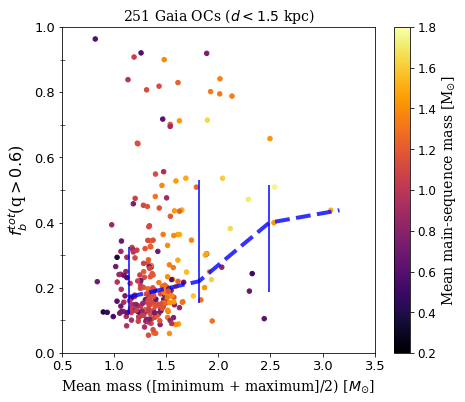

In [33]:
fig = plt.figure(figsize=(7,6))
ax = plt.subplot(111)
plt.axis([0.5,3.5,0,1.00])
ax.set_xlabel(r"Mean mass ([minimum + maximum]/2) [$M_{\odot}$]", fontdict=font)
ax.set_ylabel(r"$f_{b}^{ tot}$(q$>0.6$)", fontsize=16, fontdict=font)

ax.yaxis.set_minor_locator(MultipleLocator(0.1))
ax.tick_params(which="minor", direction='inout', length=5.)

ok = (finaltable["AgeNN"] > 0) & \
(finaltable["fb_sigu"]+finaltable["fb_sigl"] < maximum_bf_sigu_sigl_sum)
print(sum(ok), "clusters with ages and ok f_b uncertainties")

sc = ax.scatter(0.5*(finaltable["mass_max"][ok]+finaltable["mass_min"][ok]), 
                finaltable["fb_tot_qlim06"][ok],
                marker="o", c=finaltable["mean_mass"], vmin=0.2, vmax=1.8,
                s=20, label="_nolegend_", cmap="inferno", zorder=10)
cb = plt.colorbar(sc)
cb.set_label(r"Mean main-sequence mass [M$_{\odot}$]", fontsize=14, fontdict=font)
cb.ax.tick_params(labelsize=12)

plt.title(r"251 Gaia OCs ($d<1.5$ kpc)", fontdict=font)

# Overplot running median
total_bins = 5
bins = np.linspace(0.8, 3.5, total_bins)
delta = bins[1]-bins[0]
stat = np.zeros((total_bins, 3))   # list of total_bins elements, with 3 elements each

# automatic calculation of the quantiles:
for k in np.arange(total_bins-1):
    stat[k,:] = np.quantile(finaltable["fb_tot_qlim06"][ok & (0.5*(finaltable["mass_max"]+finaltable["mass_min"]) > bins[k]) & (0.5*(finaltable["mass_max"]+finaltable["mass_min"]) < bins[k+1])],
                         [.16,.50,.84])
# y axis has the middle component (50th percentile, median) for all rows: for all middeling positions of the bins.
plt.errorbar(bins+delta/2,stat[:,1], yerr=[stat[:,1]-stat[:,0], stat[:,2]-stat[:,1]], c="b", fmt="none", zorder=20)
# it also plots the 9th errorbar, but as it is full of 0's, we don't see it.
# It is necessary to plot bins without the last element, because for this no stats is calculated (it is the last right border)
plt.plot(bins[:-1]+delta/2,stat[:-1, 1],'b--',lw=4, alpha=.8, zorder=30)

plt.savefig("im/mass_BF_tot_scatterplot_auxmeanmass.png", dpi=300)

187 clusters with ages and ok f_b uncertainties


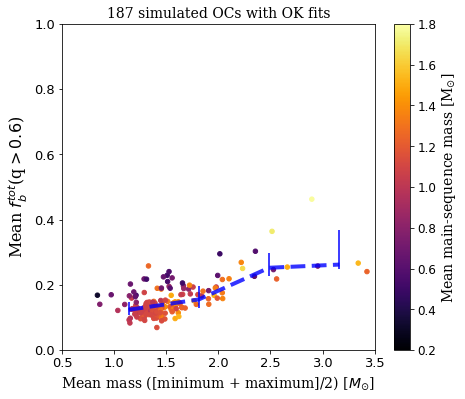

In [42]:
fig = plt.figure(figsize=(7,6))
ax = plt.subplot(111)
plt.axis([0.5,3.5,0,1.00])
ax.set_xlabel(r"Mean mass ([minimum + maximum]/2) [$M_{\odot}$]", fontdict=font)
ax.set_ylabel(r"Mean $f_{b}^{ tot}$(q$>0.6$)", fontsize=16, fontdict=font)

ax.yaxis.set_minor_locator(MultipleLocator(0.2))
ax.tick_params(which="minor", direction='inout', length=5.)

ok = (sim_OCs["mean_sB_50"] <= 0.22) * (abs(sim_OCs["mean_DG_50"]+0.75) <= 0.05) * (sim_OCs["mean_fb_sigu"]+sim_OCs["mean_fb_sigl"] < maximum_bf_sigu_sigl_sum)
print(sum(ok), "clusters with ages and ok f_b uncertainties")

sc = ax.scatter(0.5*(sim_OCs["mass_max"][ok]+sim_OCs["mass_min"][ok]), 
                sim_OCs["mean_fb_tot_greater06"][ok],
                marker="o", c=sim_OCs[ok]["mean_mass"], vmin=0.2, vmax=1.8,
                s=20, label="_nolegend_", cmap="inferno", zorder=10)
cb = plt.colorbar(sc)
cb.set_label(r"Mean main-sequence mass [M$_{\odot}$]", fontsize=14, fontdict=font)
cb.ax.tick_params(labelsize=12)

plt.title(r""+str(sum(ok))+" simulated OCs with OK fits", fontdict=font)

# Overplot running median
total_bins = 5
bins = np.linspace(0.8, 3.5, total_bins)
delta = bins[1]-bins[0]
stat = np.zeros((total_bins, 3))   # list of total_bins elements, with 3 elements each

# automatic calculation of the quantiles:
for k in np.arange(total_bins-1):
    stat[k,:] = np.quantile(sim_OCs["mean_fb_tot_greater06"][ok & (0.5*(sim_OCs["mass_max"]+sim_OCs["mass_min"]) > bins[k]) & \
                                                                            (0.5*(sim_OCs["mass_max"]+sim_OCs["mass_min"]) < bins[k+1])],
                         [.16,.50,.84])
plt.errorbar(bins+delta/2,stat[:,1], yerr=[stat[:,1]-stat[:,0], stat[:,2]-stat[:,1]], c="b", fmt="none", zorder=20)
plt.plot(bins[:-1]+delta/2,stat[:-1, 1],'b--',lw=4, alpha=.8, zorder=30)    
    
plt.savefig("im/sim_mass_BF_tot_scatterplot_auxmeanmass.png", dpi=300)

## Comparison between our MCMC-estimated BF and referee's BF

In [63]:
# Results of our analysis (separate files for the Tarricq+ and Cantat+ membership lists) and also referee's:
tarricqres_with_ref = Table.read("data/mcmc_results_tarricq_summary_refereetest.fits")
cantatres_with_ref  = Table.read("data/mcmc_results_cantat_summary_refereetest.fits")
# Join the two subtables
jointres_with_ref   = vstack([tarricqres_with_ref, cantatres_with_ref])
jointres_with_ref["Cluster"] = np.array([np.char.strip(a, ' ') for a in jointres_with_ref["clus"]], dtype="S17")
mergedtable_with_ref = join(nntable, jointres_with_ref, join_type='inner')
print("Total number of OCs closer than 1.5 kpc studied through MCMC:", len(mergedtable_with_ref))

Total number of OCs closer than 1.5 kpc studied through MCMC: 378


378


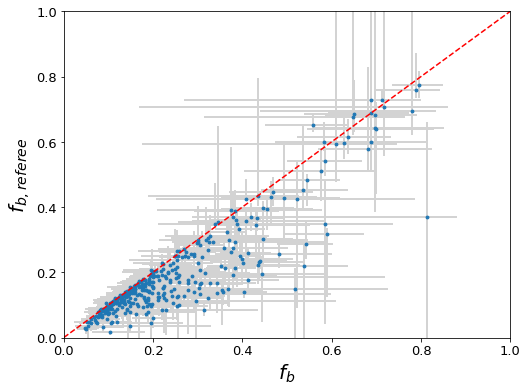

In [80]:
print(len(mergedtable_with_ref))

fig = plt.figure(figsize=(8,6))
ax = plt.subplot(111)
ax.set_xlabel(r"$f_b$", fontdict=font, fontsize=20)
ax.set_ylabel("$f_{b, referee}$", fontdict=font, fontsize=20)
#plt.xticks(np.arange(-1.0, -0.3, step=0.1))
#ax.tick_params(which="major", direction='inout', length=8.)
#ax.tick_params(which="minor", direction='inout', length=5.)
#ax.xaxis.set_minor_locator(MultipleLocator(0.05))
plt.xlim(0., 1.)
plt.ylim(0., 1.)
x_pts = np.linspace(0, 1.0, 10000)
plt.errorbar(mergedtable_with_ref["fb_50"], mergedtable_with_ref["fb_ref_50"],
             xerr=[mergedtable_with_ref["fb_sigl"], mergedtable_with_ref["fb_sigu"]],
             yerr=[mergedtable_with_ref["fb_ref_sigl"], mergedtable_with_ref["fb_ref_sigu"]], fmt='none',
             ecolor='lightgray', elinewidth=2, capsize=0, zorder=0)
plt.plot(x_pts, x_pts, c="red", linewidth=1.5, linestyle="--")
plt.scatter(mergedtable_with_ref["fb_50"], mergedtable_with_ref["fb_ref_50"], s=8)

plt.savefig("im/Comparison_fbs_all.png", dpi=300)

249


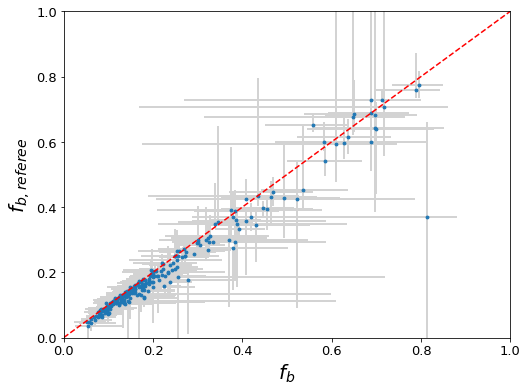

In [81]:
ok         = (mergedtable_with_ref["sB_50"] <= 0.25) * \
             (mergedtable_with_ref["sM_50"] <= 0.20) * (abs(mergedtable_with_ref["DG_50"]+0.75) <= 0.05)

print(len(mergedtable_with_ref[ok]))
fig = plt.figure(figsize=(8,6))
ax = plt.subplot(111)
ax.set_xlabel(r"$f_b$", fontdict=font, fontsize=20)
ax.set_ylabel("$f_{b, referee}$", fontdict=font, fontsize=20)
#plt.xticks(np.arange(-1.0, -0.3, step=0.1))
#ax.tick_params(which="major", direction='inout', length=8.)
#ax.tick_params(which="minor", direction='inout', length=5.)
#ax.xaxis.set_minor_locator(MultipleLocator(0.05))
plt.xlim(0., 1.)
plt.ylim(0., 1.)
x_pts = np.linspace(0, 1.0, 10000)
plt.errorbar(mergedtable_with_ref["fb_50"][ok], mergedtable_with_ref["fb_ref_50"][ok],
             xerr=[mergedtable_with_ref["fb_sigl"][ok], mergedtable_with_ref["fb_sigu"][ok]],
             yerr=[mergedtable_with_ref["fb_ref_sigl"][ok], mergedtable_with_ref["fb_ref_sigu"][ok]], fmt='none',
             ecolor='lightgray', linewidth=2, capsize=0, zorder=0)
plt.plot(x_pts, x_pts, c="red", linewidth=1.5, linestyle="--")
plt.scatter(mergedtable_with_ref["fb_50"][ok], mergedtable_with_ref["fb_ref_50"][ok], s=8)

plt.savefig("im/Comparison_fbs_selected_obs_OCs.png", dpi=300)

In [6]:
# Complete Cantat-Gaudin+2020 Table 1
nntable = Table.read("data/CantatGaudin2020_table1.fits")
nntable["Cluster"] = np.array([np.char.strip(a, ' ') for a in nntable["Cluster"]], dtype="S17")
nntable_age_nonull = nntable[ nntable["AgeNN"]!= 0. ]
print(nntable)

jointres_with_ref   = Table.read("data/Catalogue_obs_OCs_DEFINITIVE.fits")
jointres_with_ref["Cluster"] = np.array([np.char.strip(a, ' ') for a in jointres_with_ref["Cluster"]], dtype="S17")
print(jointres_with_ref)

mergedtable_with_ref = join(nntable, jointres_with_ref, join_type='inner')
print("Total number of OCs closer than 1.5 kpc studied through MCMC:", len(mergedtable_with_ref))

  Cluster    RA_ICRS DE_ICRS ... _RA_icrs _DE_icrs
               deg     deg   ...   deg      deg   
------------ ------- ------- ... -------- --------
     ASCC_10   51.87  34.981 ...    51.87   34.981
    ASCC_101 288.399  36.369 ...  288.399   36.369
    ASCC_105 295.548  27.366 ...  295.548   27.366
    ASCC_107 297.164  21.987 ...  297.164   21.987
    ASCC_108 298.306  39.349 ...  298.306   39.349
     ASCC_11  53.056  44.856 ...   53.056   44.856
    ASCC_110 300.742  33.528 ...  300.742   33.528
    ASCC_111 302.891  37.515 ...  302.891   37.515
    ASCC_113 317.933  38.638 ...  317.933   38.638
    ASCC_114  324.99  53.997 ...   324.99   53.997
         ...     ...     ... ...      ...      ...
      UPK_99 312.427  25.488 ...  312.427   25.488
  Waterloo_1  64.682  52.863 ...   64.682   52.863
  Waterloo_7 111.532  -15.09 ...  111.532   -15.09
Westerlund_1  251.76 -45.852 ...   251.76  -45.852
Westerlund_2  156.01 -57.758 ...   156.01  -57.758
   vdBergh_1  99.275   3.078 ..

203


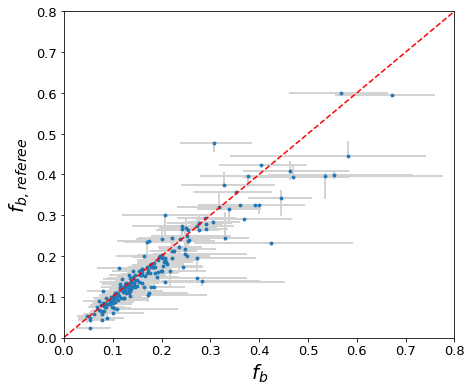

In [13]:
print(len(jointres_with_ref))

fig = plt.figure(figsize=(7,6))
ax = plt.subplot(111)
ax.set_xlabel(r"$f_b$", fontdict=font, fontsize=20)
ax.set_ylabel("$f_{b, referee}$", fontdict=font, fontsize=20)
#plt.xticks(np.arange(-1.0, -0.3, step=0.1))
#ax.tick_params(which="major", direction='inout', length=8.)
#ax.tick_params(which="minor", direction='inout', length=5.)
#ax.xaxis.set_minor_locator(MultipleLocator(0.05))
plt.xlim(0., 0.8)
plt.ylim(0., 0.8)
x_pts = np.linspace(0, 1.0, 10000)
plt.errorbar(jointres_with_ref["fb_50"], jointres_with_ref["fb_3sScut_50"],
             xerr=[jointres_with_ref["fb_sigl"], jointres_with_ref["fb_sigu"]],
             yerr=[jointres_with_ref["fb_3sScut_sigl"], jointres_with_ref["fb_3sScut_sigu"]], fmt='none',
             ecolor='lightgray', elinewidth=2, capsize=0, zorder=0)
plt.plot(x_pts, x_pts, c="red", linewidth=1.5, linestyle="--")
plt.scatter(jointres_with_ref["fb_50"], jointres_with_ref["fb_3sScut_50"], s=8)

plt.savefig("im/Comparison_fbs_final_sample.png", dpi=300)

249


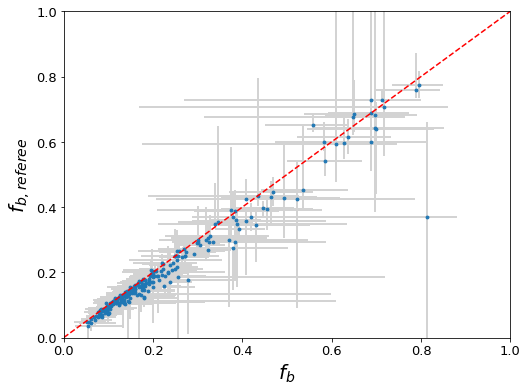

In [81]:
ok         = (mergedtable_with_ref["sB_50"] <= 0.25) * \
             (mergedtable_with_ref["sM_50"] <= 0.20) * (abs(mergedtable_with_ref["DG_50"]+0.75) <= 0.05)

print(len(mergedtable_with_ref[ok]))
fig = plt.figure(figsize=(8,6))
ax = plt.subplot(111)
ax.set_xlabel(r"$f_b$", fontdict=font, fontsize=20)
ax.set_ylabel("$f_{b, referee}$", fontdict=font, fontsize=20)
#plt.xticks(np.arange(-1.0, -0.3, step=0.1))
#ax.tick_params(which="major", direction='inout', length=8.)
#ax.tick_params(which="minor", direction='inout', length=5.)
#ax.xaxis.set_minor_locator(MultipleLocator(0.05))
plt.xlim(0., 1.)
plt.ylim(0., 1.)
x_pts = np.linspace(0, 1.0, 10000)
plt.errorbar(mergedtable_with_ref["fb_50"][ok], mergedtable_with_ref["fb_ref_50"][ok],
             xerr=[mergedtable_with_ref["fb_sigl"][ok], mergedtable_with_ref["fb_sigu"][ok]],
             yerr=[mergedtable_with_ref["fb_ref_sigl"][ok], mergedtable_with_ref["fb_ref_sigu"][ok]], fmt='none',
             ecolor='lightgray', linewidth=2, capsize=0, zorder=0)
plt.plot(x_pts, x_pts, c="red", linewidth=1.5, linestyle="--")
plt.scatter(mergedtable_with_ref["fb_50"][ok], mergedtable_with_ref["fb_ref_50"][ok], s=8)

plt.savefig("im/Comparison_fbs_selected_obs_OCs.png", dpi=300)